# Research Project - Term 2

## Pricing Alternative (Illiquid) Assets by replicating their cash flows through a portfolio of listed equity and fixed income instruments

### Discussion Points with Professor Mertens: 

### Meeting Notes from 1st July

- From the panel data, calculate the expected return per fund and across funds (this is your market return) - do the same process across cumaulative distributions and cumalative contributions
- Plot the security market line and understand the beta of firms with respect to the above market returns
- Compare the risk adjusted performance of private vs public investments of similar types 
- Plot the returns per fund against the changes in interest rates 
- Try building a CAPM but for Private funds

### What are some of the biases in our analysis and how can we resolve them? 

- Do we need to calculate the log of absolute returns given below? Before calculating the betas I mean. The timeframe has been cascaded on a quarterly basis. Also log returns create an issue with null values.
---
- Some of the funds close, not all funds will run for the whole 20years
---

- Why does transaction amount for a value transaction decline in value when the fund retruns are increasing?

**The value represent the net asset value / fair value. If distributions are getting paid back to the investor, the value of the fund will drop, so the value will be typically lower.**

---
- Some funds are originated very late itself (Not all funds would have opened in 2000Q1, we need to somehow normalise data to resolve this issue, what are the potential options?)
---
- 3,835 funds seem to be too much when we are plotting the SML, shall we reduce the fund data?

In [1]:
## we start with importing the required libraries

from __future__ import division

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display
import sklearn
from scipy import stats
from sklearn.cluster import KMeans
import plotly.express as px
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from pyspark.sql.functions import datediff,col

## for visualizations

import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.globals import ThemeType
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
pd.options.display.float_format = '{:.3f}'.format

## Data Acquired from Preqin (WRDS)

#### Preqin: https://www.preqin.com/
---
#### WRDS: https://wrds-www.wharton.upenn.edu/

In [3]:
benchmark_data = pd.read_csv('benchmark_data.csv')
cashflow_data = pd.read_csv('cashflow_data.csv')
fund_details = pd.read_csv('fund_details.csv')
fund_historic_performance = pd.read_csv('fund_historic_performance.csv')
fund_terms = pd.read_csv('fund_terms.csv')
Investor_Details = pd.read_csv('Investor_Details.csv')
Investor_Portfolio = pd.read_csv('Investor_Portfolio.csv')
manager_details = pd.read_csv('manager_details.csv')
manager_investment_types = pd.read_csv('manager_investment_types.csv')
buyout_deals_details = pd.read_csv("buyout_deals_details.csv",encoding='latin-1')
venture_deals_details = pd.read_csv('venture_deals_details.csv', encoding='latin-1')

## Data Cleanup

### Task 1: Let's try to understand which of these data sources would actually be useful for our modelling. Understanding the potential of given raw data

In [4]:
# display(cashflow_data.head(5)) # used for primary cashflow model

# display(fund_details.head(5)) # using this as a base for the fund category and the name of the firms

# display(manager_details.head(5)) ## details about the firm, which are not important for the modelling purpose

# display(manager_investment_types.head(5)) ### not useful for pricing our cashflows

# display(benchmark_data.head(5))

# display(fund_historic_performance.head(5))

# display(fund_terms.head(5)) ### not useful as most of the values are null 

# display(Investor_Details.head(5)) ### not useful for pricing our cashflows also needs a lot of data cleanup

# display(Investor_Portfolio.head(5)) ## 70% of the data has null values - so pretty useless

# display(venture_deals_details.head(5)) ## could be useful but we don't know as of now if that's the case

# display(buyout_deals_details.head(5)) ## could be useful but we don't know as of now if that's the case

In [5]:
# let us check the usefulness of fund_terms

# display(fund_terms.head(5))
# display(fund_terms.describe())
# display(fund_terms.isna().sum())
# display(fund_terms.info())

# let us check the usefulness of Investor_Details

# display(Investor_Details.head(5))
# display(Investor_Details.describe())
# display(Investor_Details.isna().sum())
# display(Investor_Details.info())


# # let us check the usefulness of Investor_Details

# display(Investor_Portfolio.head(5))
# display(Investor_Portfolio.describe())
# display(Investor_Portfolio.isna().sum())
# display(Investor_Portfolio.info())

## let us check the usefulness of Investor_Details

# display(manager_details.describe())
# display(manager_details.isna().sum())
# display(manager_details.info())

In [6]:
# Investor_Details.Firm_Type.unique()

In [7]:
display(manager_details.FirmType.unique())
display(manager_details.MainFirmStrategy.unique())

array(['Private Equity Firm', 'Private Equity Firm (Investor)',
       'Private Equity Fund of Funds Manager',
       'Secondary Fund of Funds Manager', 'Investment Company'],
      dtype=object)

array(['Venture Capital', 'Buyout', 'Growth', 'Balanced', nan,
       'Distressed PE', 'Mezzanine', 'Natural Resources',
       'Direct Secondaries', 'Unknown', 'Timber', 'Venture Debt',
       'Co-investment', 'Hybrid', 'CLO/CDO/Senior Loan'], dtype=object)

In [8]:
################################# display(fund_historic_performance.head(5)) ####################################################

# fund_historic_performance.describe()
# fund_historic_performance.isna().sum()
# fund_historic_performance.info()

# display(buyout_deals_details.describe())
# display(buyout_deals_details.isna().sum())
# display(buyout_deals_details.info())

# display(benchmark_data.head(5))
# display(benchmark_data.describe())
# display(benchmark_data.isna().sum())
# display(benchmark_data.info())


### Converting important date columns to pd.datetime format

In [9]:
## cashflow_data.describe()
cashflow_data['transaction_date'] = pd.to_datetime(cashflow_data['transaction_date'])
fund_historic_performance['Date_Reported'] = pd.to_datetime(fund_historic_performance['Date_Reported'])
benchmark_data['qdate'] = pd.to_datetime(benchmark_data['qdate'])
benchmark_data['fund_vintage'] = pd.to_datetime(benchmark_data['fund_vintage'])

In [10]:
display(cashflow_data.head(5))
# display(fund_historic_performance.head(5))
# display(benchmark_data.head(5))
# display(fund_details.head(5))

,Fund_Id,Firm_Id,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
0,3,152327,2000-02-15,Capital Call,-13829,-10008370,8086710,-1921660
1,3,152327,2000-02-15,Distribution,28596,-10008370,8115306,-1893064
2,3,152327,2000-03-31,Value,6300820,-10008370,8115306,-1893064
3,3,152327,2000-05-16,Distribution,86105,-10008370,8201411,-1806959
4,3,152327,2000-06-30,Value,6266070,-10008370,8201411,-1806959


In [11]:
fund_details_clean=fund_details[['Firm_Id','Firm_Name','Fund_Id','Fund_Name','Vintage','Fund_Type']].copy()
display(fund_details_clean.head(5))

fund_type_data=manager_details[['Firm_Id','MainFirmStrategy']].copy()
fund_type_data = fund_type_data.rename(columns={'MainFirmStrategy': 'Firm_Strategy'})
display(fund_type_data.head(5))

fund_details_clean.info()

,Firm_Id,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type
0,152327,Brown Brothers Harriman,2,1818 Fund,1989,Buyout
1,152327,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout
2,152327,Brown Brothers Harriman,4,1818 Fund III,1998,Buyout
3,741,Riverside Company,7,Riverside Capital Appreciation Fund 1995,1995,Buyout
4,741,Riverside Company,8,Riverside Capital Appreciation Fund 1998,1998,Buyout


,Firm_Id,Firm_Strategy
0,1,Venture Capital
1,2,Buyout
2,3,Growth
3,4,Buyout
4,7,Balanced


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41061 entries, 0 to 41060
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Firm_Id    41061 non-null  int64 
 1   Firm_Name  41061 non-null  object
 2   Fund_Id    41061 non-null  int64 
 3   Fund_Name  41061 non-null  object
 4   Vintage    41061 non-null  int64 
 5   Fund_Type  41061 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.9+ MB


In [12]:
fund_cashflow_data = pd.merge(fund_details_clean,cashflow_data,how = 'inner', on = ['Fund_Id','Firm_Id'])
fund_cf_clean = pd.merge(fund_type_data,fund_cashflow_data,how = 'right', on = ['Firm_Id'])

# # display(fund_cashflow_data.head(5))
# display(fund_cashflow_data.nunique())
# display(fund_cashflow_data.info())

display(fund_cf_clean.nunique())
# display(fund_cf_clean.info())
display(fund_cf_clean.describe(include='all'))

Firm_Id                      1295
Firm_Strategy                  11
Firm_Name                    1289
Fund_Id                      3835
Fund_Name                    3835
Vintage                        42
Fund_Type                      14
transaction_date             3298
transaction_type                3
transaction_amount         173075
Cumulative_Contribution     46217
Cumulative_Distribution     48112
Net_CashFlow                99915
dtype: int64

,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
count,248926.000,228199,248926,248926.000,248926,248926.000,248926,248926,248926,248926.000,248926.000,248926.000,248926.000
unique,NaN,11,1289,NaN,3835,NaN,14,3298,3,NaN,NaN,NaN,NaN
top,NaN,Buyout,Adams Street Partners,NaN,Liberty Partners Pool V,NaN,Buyout,2019-12-31 00:00:00,Value,NaN,NaN,NaN,NaN
freq,NaN,115053,4850,NaN,303,NaN,94153,2787,133816,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,9635.371,NaN,NaN,17049.592,NaN,2005.856,NaN,NaN,NaN,2280206.880,-7507841.641,6440535.579,-1067306.062
std,34027.185,NaN,NaN,21360.070,NaN,6.836,NaN,NaN,NaN,3847353.233,3156559.754,10912082.865,9962063.756
min,2.000,NaN,NaN,3.000,NaN,1980.000,NaN,NaN,NaN,-14100000.000,-22092378.000,-64801.000,-20066415.000
25%,355.000,NaN,NaN,1988.000,NaN,2001.000,NaN,NaN,NaN,-156.000,-9947887.000,109242.000,-5629200.000


## What are the different types of firm and fund strategies?

In [13]:
display(fund_cf_clean.Firm_Strategy.unique())
display(fund_cf_clean.Fund_Type.unique())

array(['Buyout', 'Venture Capital', 'Balanced', 'Growth', nan,
       'Natural Resources', 'Direct Secondaries', 'Distressed PE',
       'Co-investment', 'Hybrid', 'Mezzanine', 'Venture Debt'],
      dtype=object)

array(['Buyout', 'Venture (General)', 'Growth', 'Fund of Funds',
       'Early Stage', 'Expansion / Late Stage', 'Early Stage: Seed',
       'Balanced', 'Co-investment', 'Secondaries',
       'Early Stage: Start-up', 'Co-Investment Multi-Manager',
       'Turnaround', 'Direct Secondaries'], dtype=object)

In [14]:
# # find rows with null values

# is_NaN = fund_cf_data.isnull()
# row_has_NaN = is_NaN.any(axis=1)
# rows_with_NaN = fund_cf_data[row_has_NaN]

# print(rows_with_NaN.head(5))

In [88]:
## lets replace null values in the firm_strategy column with the most frequent strategy

alt_asset_cf = fund_cf_clean.apply(lambda Firm_Strategy: Firm_Strategy.fillna(Firm_Strategy.value_counts().index[0]))
## lets check for the nan values
display(alt_asset_cf.isna().sum())
display(alt_asset_cf.Firm_Strategy.unique())
display(alt_asset_cf.transaction_type.unique())

Firm_Id                    0
Firm_Strategy              0
Firm_Name                  0
Fund_Id                    0
Fund_Name                  0
Vintage                    0
Fund_Type                  0
transaction_date           0
transaction_type           0
transaction_amount         0
Cumulative_Contribution    0
Cumulative_Distribution    0
Net_CashFlow               0
dtype: int64

array(['Buyout', 'Venture Capital', 'Balanced', 'Growth',
       'Natural Resources', 'Direct Secondaries', 'Distressed PE',
       'Co-investment', 'Hybrid', 'Mezzanine', 'Venture Debt'],
      dtype=object)

array(['Capital Call', 'Distribution', 'Value'], dtype=object)

# Final Alternative Assets Cashflow Dataframe

In [16]:
display(alt_asset_cf.head(2))
display(alt_asset_cf.tail(2))
display(alt_asset_cf.info())

,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
0,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Capital Call,-13829,-10008370,8086710,-1921660
1,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Distribution,28596,-10008370,8115306,-1893064


,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
248924,398714,Venture Capital,Siena Venture Partners,124483,Siena Secondary Fund I,2021,Expansion / Late Stage,2021-06-30,Capital Call,-1500000,-1500000,0,-1500000
248925,398714,Venture Capital,Siena Venture Partners,124483,Siena Secondary Fund I,2021,Expansion / Late Stage,2021-06-30,Value,1785000,-1500000,0,-1500000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 248926 entries, 0 to 248925
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Firm_Id                  248926 non-null  int64         
 1   Firm_Strategy            248926 non-null  object        
 2   Firm_Name                248926 non-null  object        
 3   Fund_Id                  248926 non-null  int64         
 4   Fund_Name                248926 non-null  object        
 5   Vintage                  248926 non-null  int64         
 6   Fund_Type                248926 non-null  object        
 7   transaction_date         248926 non-null  datetime64[ns]
 8   transaction_type         248926 non-null  object        
 9   transaction_amount       248926 non-null  int64         
 10  Cumulative_Contribution  248926 non-null  int64         
 11  Cumulative_Distribution  248926 non-null  int64         
 12  Net_CashFlow    

None

## Alternative Assets Cashflow Dataframe Glossary: 

---

**Firm_ID**: Unique identifier of the fund manager/firm. 

**Firm Strategy** : The main investment strategy of the firm

**Firm_Name**: Name of the fund manager/Firm

**Fund_Id**: Unique identifier of the fund.

**Fund_Name**: Name of the fund.

**Vintage**: The fund's first year of investment/capital call

**Fund Type**: Strategy of the fund

**Transaction Date:** Date of the transaction.

**Transaction Type:** Type of transaction.

Capital Call: No specific frequency with a given year - capital call can occur at irregual intervals https://www.securedocs.com/blog/private-equity-what-is-a-capital-call

Distribution: No specific frequency observed for now, but can be a quarterly cashflow data https://static1.squarespace.com/static/5dc0411d1488ea3bce3fea1b/t/5e343d4b239e650b841e82d1/1580481868131/Hatteras_ThePrivateEquityCashFlowModel_Whitepaper.pdf

Value: The ‘Value’ transaction type simply refers to the fair market value of the funds portfolio at that given date. They always occur at a per quarter frequency. The value represent the net asset value / fair value. If distributions are getting paid back to the investor, the value of the fund will drop, so the value will be typically lower.


**Transaction Amount:** Transaction amount. Can be negative or positive.

**Cumulative Contribution:** Cumulative amount contributed to the fund.

**Cumulative Distribution:** Cumulative amount distributed from the fund.

**Net Cashflow:** Cumulative amount of cash flow into or out of the fund. (Cumulative Contribution + Cumulative Distribution). A positive net cashflow means that you have disstributed more to LPs than what they have contributed to the fund, which also sort of means that your fund is in a good state.

## Data Exploration

In [17]:
## checking if one of the most popular funds are part of the alt asset dataframe

print('Sequoia Capital' in alt_asset_cf['Firm_Name'].unique())

True


In [18]:
# alt_asset_cf.loc[alt_asset_cf['vintage'] == 2000]

In [19]:
display(min(alt_asset_cf.transaction_date))
display(max(alt_asset_cf.transaction_date))
display(min(alt_asset_cf.Vintage))
display(max(alt_asset_cf.Vintage))

Timestamp('2000-01-01 00:00:00')

Timestamp('2021-06-30 00:00:00')

1980

2021

### Duration of our Analysis: We have data from 1st Jan 2000 to 30th June 2021

In [20]:
## filtering data with transaction_types to understand what it could mean

display(alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Distribution'].head(2))
display(alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Value'].head(5))
display(alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Capital Call'].head(2))

,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
1,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Distribution,28596,-10008370,8115306,-1893064
3,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-05-16,Distribution,86105,-10008370,8201411,-1806959


,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
2,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-03-31,Value,6300820,-10008370,8115306,-1893064
4,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-06-30,Value,6266070,-10008370,8201411,-1806959
6,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-09-30,Value,5848550,-10008370,8291829,-1716541
8,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-12-31,Value,5234750,-10008370,9801555,-206815
10,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-03-31,Value,5229270,-10008370,9811744,-196626


,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow
0,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Capital Call,-13829,-10008370,8086710,-1921660
15,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-11-15,Capital Call,-8489,-10016859,11896567,1879708


### Task 1: Let's make cumulative contribution values positive for seamless visualization

Note cumalative contribution is basically the source of funds,and hence was labelled negative.

In [21]:
alt_asset_cf['Cumulative_Contribution']=abs(alt_asset_cf['Cumulative_Contribution'])

## we can also calculate the cumulative returns as net_cashflow/Cumulative_Contribution

alt_asset_cf["Fund_Return"]=(alt_asset_cf["Net_CashFlow"]/alt_asset_cf["Cumulative_Contribution"])

display(alt_asset_cf.head(5))

# alt_asset_dummy=alt_asset_cf.loc[alt_asset_cf['Cumulative_Contribution'] < 0]
# alt_asset_dummy.describe()
# display(alt_asset_cf.loc[alt_asset_cf['Fund_Return'] > 0])

,Firm_Id,Firm_Strategy,Firm_Name,Fund_Id,Fund_Name,Vintage,Fund_Type,transaction_date,transaction_type,transaction_amount,Cumulative_Contribution,Cumulative_Distribution,Net_CashFlow,Fund_Return
0,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Capital Call,-13829,10008370,8086710,-1921660,-0.192
1,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Distribution,28596,10008370,8115306,-1893064,-0.189
2,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-03-31,Value,6300820,10008370,8115306,-1893064,-0.189
3,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-05-16,Distribution,86105,10008370,8201411,-1806959,-0.181
4,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-06-30,Value,6266070,10008370,8201411,-1806959,-0.181


### Task 2: Create a new column called transaction quarter and vintage quarter
### Task 3: Calculate the age of the fund (in years) for a more accurate representation of returns

In [22]:
alt_asset_cf['transaction_quarter'] = alt_asset_cf['transaction_date'].dt.to_period('Q')
alt_asset_cf['transaction_year'] = alt_asset_cf['transaction_date'].dt.year
alt_asset_cf.columns = map(str.lower, alt_asset_cf.columns)
alt_asset_cf.head()

,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,transaction_amount,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year
0,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Capital Call,-13829,10008370,8086710,-1921660,-0.192,2000Q1,2000
1,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-02-15,Distribution,28596,10008370,8115306,-1893064,-0.189,2000Q1,2000
2,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-03-31,Value,6300820,10008370,8115306,-1893064,-0.189,2000Q1,2000
3,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-05-16,Distribution,86105,10008370,8201411,-1806959,-0.181,2000Q2,2000
4,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-06-30,Value,6266070,10008370,8201411,-1806959,-0.181,2000Q2,2000


In [23]:
## to confirm that there are no duplicate values

duplicate = alt_asset_cf[alt_asset_cf.duplicated()]
 
duplicate

,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,transaction_amount,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year


In [24]:
alt_asset_value = alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Value']
alt_asset_distr = alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Distribution']
alt_asset_call = alt_asset_cf.loc[alt_asset_cf['transaction_type'] == 'Capital Call']
display(alt_asset_value.fund_name.nunique())
display(alt_asset_distr.fund_name.nunique())
display(alt_asset_call.fund_name.nunique())

3835

3196

3725

In [25]:
display(alt_asset_value.loc[alt_asset_value['transaction_amount'] < 0])

print("There are no negative fair market values which can be checked with the transaction amount")

display(alt_asset_value.loc[alt_asset_value['transaction_amount'] == 0].head(5))

,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,transaction_amount,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year


There are no negative fair market values which can be checked with the transaction amount


,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,transaction_amount,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year
94,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2010-12-31,Value,0,10010451,17137892,7127441,0.712,2010Q4,2010
95,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2021-03-31,Value,0,10010451,17137892,7127441,0.712,2021Q1,2021
205,741,Buyout,Riverside Company,9,Riverside Capital Appreciation Fund 2000,2000,Buyout,2017-12-31,Value,0,9140000,16080000,6940000,0.759,2017Q4,2017
206,741,Buyout,Riverside Company,9,Riverside Capital Appreciation Fund 2000,2000,Buyout,2018-03-31,Value,0,9140000,16080000,6940000,0.759,2018Q1,2018
207,741,Buyout,Riverside Company,9,Riverside Capital Appreciation Fund 2000,2000,Buyout,2018-06-30,Value,0,9140000,16080000,6940000,0.759,2018Q2,2018


## We will only be using the value transaction type as value transactions give us the fair market value of the fund - as per the data provider: preqin

### Insight: We have 3,835 funds in our dataset and all value transactions have individual funds associated with it, which means we can take the value transactions as our base dataset

In [26]:
alt_1818 = alt_asset_value.loc[alt_asset_value['fund_name'] == '1818 Fund II']

## lets browse through the fund values of one the funds in our dataset

alt_1818

,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,transaction_amount,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year
2,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-03-31,Value,6300820,10008370,8115306,-1893064,-0.189,2000Q1,2000
4,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-06-30,Value,6266070,10008370,8201411,-1806959,-0.181,2000Q2,2000
6,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-09-30,Value,5848550,10008370,8291829,-1716541,-0.172,2000Q3,2000
8,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-12-31,Value,5234750,10008370,9801555,-206815,-0.021,2000Q4,2000
10,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-03-31,Value,5229270,10008370,9811744,-196626,-0.020,2001Q1,2001
12,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-06-30,Value,5209930,10008370,9822629,-185741,-0.019,2001Q2,2001
14,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-09-30,Value,4234670,10008370,11896567,1888197,0.189,2001Q3,2001
17,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2001-12-31,Value,4157120,10016859,11975763,1958904,0.196,2001Q4,2001
18,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2002-03-31,Value,4150710,10016859,11975763,1958904,0.196,2002Q1,2002
19,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2002-06-30,Value,4142740,10016859,11975763,1958904,0.196,2002Q2,2002


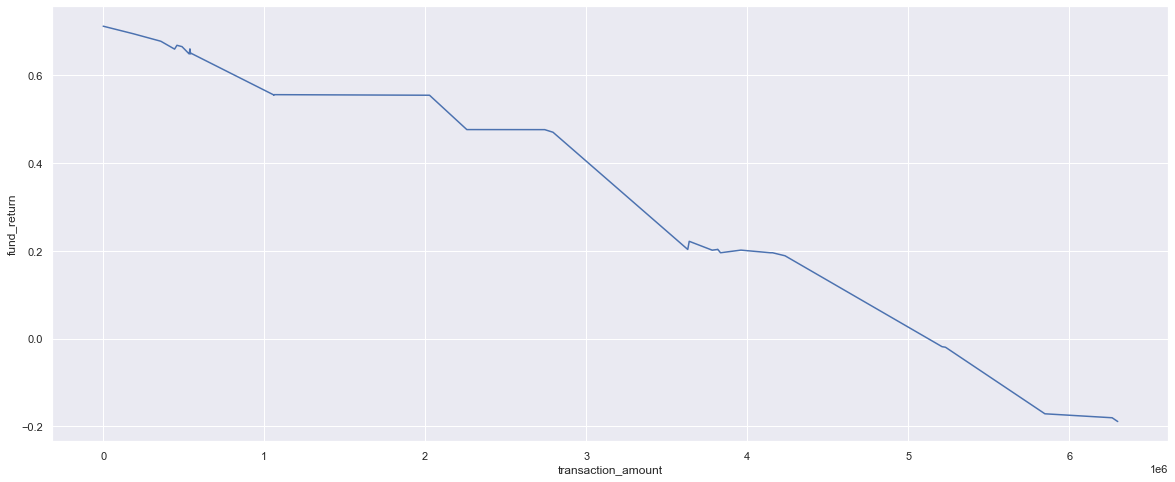

In [87]:
sns.set_theme(style="darkgrid")

ax=sns.lineplot(x = "transaction_amount", y = "fund_return", data = alt_1818)

plt.show()

---

## Plot the security market line for the fund returns against the benchmark fund and the returns of the S&P 500

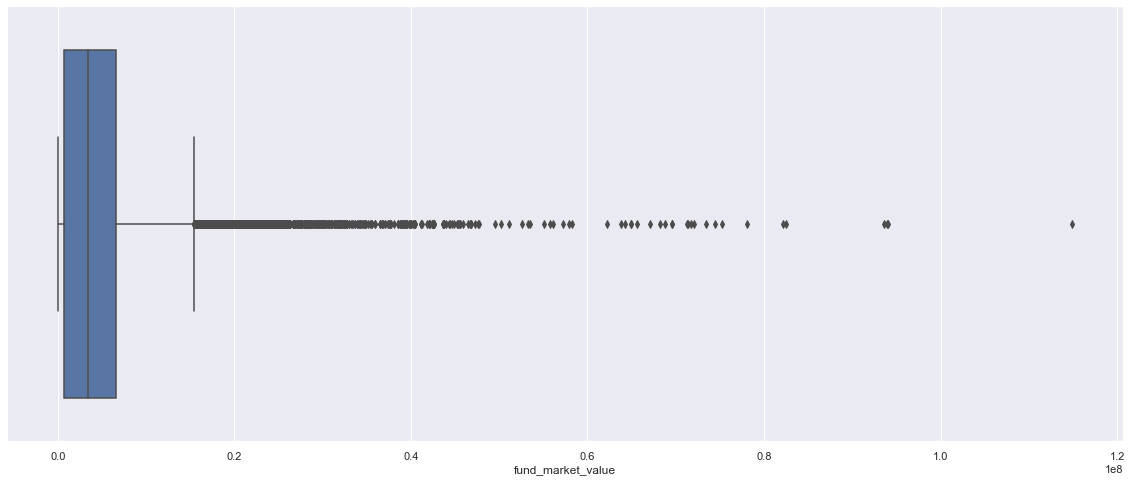

In [85]:
sns.boxplot(x=alt_asset_value.fund_market_value)
plt.show()

In [29]:
alt_asset_value=alt_asset_value.rename(columns = {'transaction_amount':'fund_market_value'})
alt_asset_value.head(2)

,firm_id,firm_strategy,firm_name,fund_id,fund_name,vintage,fund_type,transaction_date,transaction_type,fund_market_value,cumulative_contribution,cumulative_distribution,net_cashflow,fund_return,transaction_quarter,transaction_year
2,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-03-31,Value,6300820,10008370,8115306,-1893064,-0.189,2000Q1,2000
4,152327,Buyout,Brown Brothers Harriman,3,1818 Fund II,1993,Buyout,2000-06-30,Value,6266070,10008370,8201411,-1806959,-0.181,2000Q2,2000


In [30]:
quart_exp_cf=alt_asset_value.groupby(['fund_name','transaction_quarter'],as_index=False).agg(
    fund_market_value = ('fund_market_value','mean'),
    exp_return=('fund_return','mean'), 
    exp_contr=('cumulative_contribution','mean'),
    exp_distr=('cumulative_distribution','mean'))

trans_df_series = quart_exp_cf[["fund_name", "transaction_quarter","fund_market_value"]]
trans_df_series = trans_df_series.pivot(index='transaction_quarter', columns='fund_name', values='fund_market_value')

In [31]:
trans_df_series.head(5)

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,Z Capital Partners III,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV
transaction_quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,NaN,NaN,NaN,NaN,NaN,6300820.000,NaN,NaN,NaN,8864220.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q2,NaN,NaN,NaN,NaN,NaN,6266070.000,NaN,NaN,NaN,8130370.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q3,NaN,NaN,NaN,NaN,NaN,5848550.000,NaN,NaN,NaN,6925680.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q4,NaN,NaN,NaN,NaN,NaN,5234750.000,NaN,NaN,NaN,6267830.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001Q1,NaN,NaN,NaN,NaN,NaN,5229270.000,NaN,NaN,NaN,4890660.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fund returns are basically calculated on value transactions only: 

- $\Delta$NAV (t) = NAV(t) - NAV (t-1)


- Contributions (t) = CumContr (t) - CumContr (t-1)


- Distributions (t) = CumDistr. (t) - CumDistr. (t-1)


- $\Delta$NAV (t) = Contr.(t) - Disr.(t) + Net Proceeds


- Net Proceeds(t) = $\Delta$NAV (t) - Contr.(t) + Distr.(t)


- **Returns are basically = Net Proceeds / NAV (t-1)**


Interestingly, the net asset value changes incoporating the net proceeds from Cumulative contribution and ditribution from the cashflows

In [32]:
fund_returns = (trans_df_series/trans_df_series.shift(1))-1
fund_returns.head(5)

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,Z Capital Partners III,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV
transaction_quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q2,NaN,NaN,NaN,NaN,NaN,-0.006,NaN,NaN,NaN,-0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q3,NaN,NaN,NaN,NaN,NaN,-0.067,NaN,NaN,NaN,-0.148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q4,NaN,NaN,NaN,NaN,NaN,-0.105,NaN,NaN,NaN,-0.095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001Q1,NaN,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,-0.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating benchmark returns which are just the average of the fund returns dataset per quarter

In [33]:
fund_returns['benchmark_fund'] = fund_returns.mean(axis=1)
fund_returns['benchmark_fund']

transaction_quarter
2000Q1      NaN
2000Q2    0.157
2000Q3    1.117
2000Q4    0.094
2001Q1   -0.005
          ...  
2020Q2    0.125
2020Q3    0.168
2020Q4    0.401
2021Q1    0.091
2021Q2   -0.249
Freq: Q-DEC, Name: benchmark_fund, Length: 86, dtype: float64

In [34]:
fund_returns.head(5)

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV,benchmark_fund
transaction_quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q2,NaN,NaN,NaN,NaN,NaN,-0.006,NaN,NaN,NaN,-0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157
2000Q3,NaN,NaN,NaN,NaN,NaN,-0.067,NaN,NaN,NaN,-0.148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.117
2000Q4,NaN,NaN,NaN,NaN,NaN,-0.105,NaN,NaN,NaN,-0.095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094
2001Q1,NaN,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,-0.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005


In [35]:
fund_log_returns = np.log((trans_df_series/trans_df_series.shift(1)))
fund_log_returns.head(5)

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,Z Capital Partners III,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV
transaction_quarter,,,,,,,,,,,,,,,,,,,,,
2000Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q2,NaN,NaN,NaN,NaN,NaN,-0.006,NaN,NaN,NaN,-0.086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q3,NaN,NaN,NaN,NaN,NaN,-0.069,NaN,NaN,NaN,-0.160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000Q4,NaN,NaN,NaN,NaN,NaN,-0.111,NaN,NaN,NaN,-0.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001Q1,NaN,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,-0.248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
fund_returns.corr()

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV,benchmark_fund
fund_name,,,,,,,,,,,,,,,,,,,,,
.406 Ventures 2016 Opportunities Fund,1.000,0.137,-0.141,0.150,-1.000,NaN,0.398,NaN,NaN,NaN,...,-0.412,NaN,0.126,NaN,-0.135,-1.000,NaN,1.000,NaN,0.795
.406 Ventures Fund II,0.137,1.000,0.007,-0.021,0.442,NaN,-0.177,NaN,NaN,NaN,...,0.186,0.960,0.447,NaN,-0.149,0.113,NaN,1.000,NaN,0.085
.406 Ventures Fund III,-0.141,0.007,1.000,0.512,0.071,NaN,-0.453,NaN,NaN,NaN,...,0.043,NaN,-0.081,NaN,0.286,-0.744,NaN,1.000,NaN,-0.131
1315 Capital,0.150,-0.021,0.512,1.000,0.183,NaN,-0.031,NaN,NaN,NaN,...,-0.344,NaN,0.170,NaN,0.009,-0.298,NaN,-1.000,NaN,0.070
1315 Capital II,-1.000,0.442,0.071,0.183,1.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.076,NaN,NaN,NaN,NaN,-0.409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iNovia Investment Fund 2015,-1.000,0.113,-0.744,-0.298,NaN,NaN,-0.987,NaN,NaN,NaN,...,0.754,NaN,0.403,NaN,-0.788,1.000,NaN,NaN,NaN,0.996
iXO 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mcp Opportunity Secondary Program Fund III,1.000,1.000,1.000,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000,NaN,-1.000,NaN,NaN,1.000,NaN,1.000


In [37]:
# trans_df_series.drop('cum_return', axis=1, inplace=True)
fund_returns.describe()

fund_name,.406 Ventures 2016 Opportunities Fund,.406 Ventures Fund II,.406 Ventures Fund III,1315 Capital,1315 Capital II,1818 Fund II,2001 Brinson Partnership Fund Program,21st Century Communications Partners,32 Degrees Capital Diversified Energy Fund I,3i Eurofund I,...,ZMC II,ZN Mexico II,Zeus Private Equity Fund I,eCAPITAL IV Technologies,ff Sapphire (IV) Venture Capital Fund,iNovia Investment Fund 2015,iXO 4,mcp Opportunity Secondary Program Fund III,mcp Opportunity Secondary Program Fund IV,benchmark_fund
count,13.000,32.000,20.000,21.000,7.000,43.000,44.000,25.000,5.000,22.000,...,12.000,39.000,46.000,1.000,22.000,3.000,0.000,2.000,1.000,85.000
mean,0.542,0.130,0.390,0.138,0.330,-0.089,-0.034,-0.115,0.556,-0.155,...,0.239,0.055,0.121,1.743,0.139,0.136,NaN,0.051,0.000,inf
std,1.401,0.203,0.893,0.234,0.482,0.199,0.116,0.275,0.721,0.258,...,0.342,0.604,0.655,NaN,0.151,0.205,NaN,0.120,NaN,NaN
min,-0.277,-0.246,-0.033,-0.194,-0.172,-1.000,-0.260,-1.000,0.000,-1.000,...,-0.107,-1.000,-0.698,1.743,-0.081,0.000,NaN,-0.034,0.000,-0.249
25%,0.024,0.012,0.081,-0.024,0.076,-0.097,-0.102,-0.054,0.239,-0.169,...,0.011,-0.115,-0.001,1.743,0.062,0.019,NaN,0.009,0.000,0.094
50%,0.139,0.101,0.160,0.098,0.122,-0.013,-0.014,0.000,0.256,-0.102,...,0.130,-0.015,0.029,1.743,0.128,0.037,NaN,0.051,0.000,0.139
75%,0.246,0.194,0.328,0.245,0.472,-0.000,0.026,0.004,0.472,-0.047,...,0.255,0.030,0.108,1.743,0.188,0.204,NaN,0.094,0.000,0.270
max,5.114,0.611,4.107,0.708,1.266,0.214,0.376,0.117,1.811,0.254,...,0.974,2.713,3.973,1.743,0.597,0.372,NaN,0.136,0.000,inf


In [38]:
fund_returns = fund_returns.replace([np.inf, -np.inf], np.nan)
fund_returns = fund_returns.fillna(0)
# # fund_returns = fund_returns.replace([np.inf, -np.inf], 0, inplace=True)

### Calculating the Beta of the funds against the benchmark fund (mean fund)

In [39]:
betas = {}
for col in fund_returns.columns:
    Y = fund_returns[col]
    X = fund_returns['benchmark_fund']
    X1 = sm.add_constant(X)
    betas[col] = sm.OLS(Y, X1).fit().params

In [40]:
beta_fund = pd.DataFrame.from_dict(betas)
beta_fund=beta_fund.transpose()

In [41]:
beta_fund.reset_index(inplace=True)
beta_fund.columns = ['fund_name','alpha','beta']
beta_fund.drop(beta_fund.tail(1).index,inplace=True) 
beta_fund.head(5)

,fund_name,alpha,beta
0,.406 Ventures 2016 Opportunities Fund,-0.056,0.264
1,.406 Ventures Fund II,0.042,0.012
2,.406 Ventures Fund III,0.099,-0.015
3,1315 Capital,0.029,0.009
4,1315 Capital II,0.031,-0.008


In [42]:
# fund_exp_cf=alt_asset_cf.groupby(['fund_name'],as_index=False).agg(
#     exp_return=('fund_return','mean'), 
#     exp_contr=('cumulative_contribution','mean'),
#     exp_distr=('cumulative_distribution','mean')
# )

# fund_exp_cf.head(5)

fund_returns_mean = fund_returns.mean(axis=0)
fund_returns_mean=fund_returns_mean.to_frame()
fund_returns_mean.columns = ['exp_return']
fund_returns_mean.reset_index(inplace=True)
fund_returns_mean

,fund_name,exp_return
0,.406 Ventures 2016 Opportunities Fund,0.082
1,.406 Ventures Fund II,0.049
2,.406 Ventures Fund III,0.091
3,1315 Capital,0.034
4,1315 Capital II,0.027
...,...,...
3831,iNovia Investment Fund 2015,0.005
3832,iXO 4,0.000
3833,mcp Opportunity Secondary Program Fund III,0.001
3834,mcp Opportunity Secondary Program Fund IV,0.000


In [43]:
sml_funds = pd.merge(fund_returns_mean,beta_fund,how = 'inner', on = ['fund_name'])
sml_funds.head(5)

,fund_name,exp_return,alpha,beta
0,.406 Ventures 2016 Opportunities Fund,0.082,-0.056,0.264
1,.406 Ventures Fund II,0.049,0.042,0.012
2,.406 Ventures Fund III,0.091,0.099,-0.015
3,1315 Capital,0.034,0.029,0.009
4,1315 Capital II,0.027,0.031,-0.008


In [44]:
sml_funds.describe()

,exp_return,alpha,beta
count,3835.000,3835.000,3835.000
mean,0.182,-0.012,0.372
std,3.345,3.446,12.434
min,-0.078,-199.407,-0.885
25%,0.000,0.000,-0.009
50%,0.022,0.021,-0.001
75%,0.045,0.043,0.004
max,152.918,18.497,674.324


In [45]:
alt_fund_vintage = alt_asset_value[["fund_name","vintage"]]

alt_fund_vintage=alt_fund_vintage.drop_duplicates()

sml_vin_perf = pd.merge(sml_funds,alt_fund_vintage,how = 'right', on = ['fund_name'])

sml_vin_perf.sort_values(by='beta',ascending=False)

,fund_name,exp_return,alpha,beta,vintage
2916,Growth Capital Partners Fund IV,152.918,-199.407,674.324,2016
3133,Palatine Private Equity Impact Investing Fund,98.298,-60.316,303.576,2017
2605,ASF VI CDPQ Co-Investment,80.466,-20.289,192.838,2014
332,Latterell Venture Partners II,14.798,-11.601,50.526,2002
3213,Pentech Ventures III,15.061,-9.168,46.372,2017
...,...,...,...,...,...
2313,Accel-KKR SCP California Co-Invest,1.480,1.678,-0.380,2013
1995,Actera Partners II,1.814,2.040,-0.434,2012
2807,Technology Transfer Fund,1.395,1.634,-0.456,2019
2355,Helios Investors III,2.283,2.551,-0.513,2014


The Security Market Line can be curated as follows:


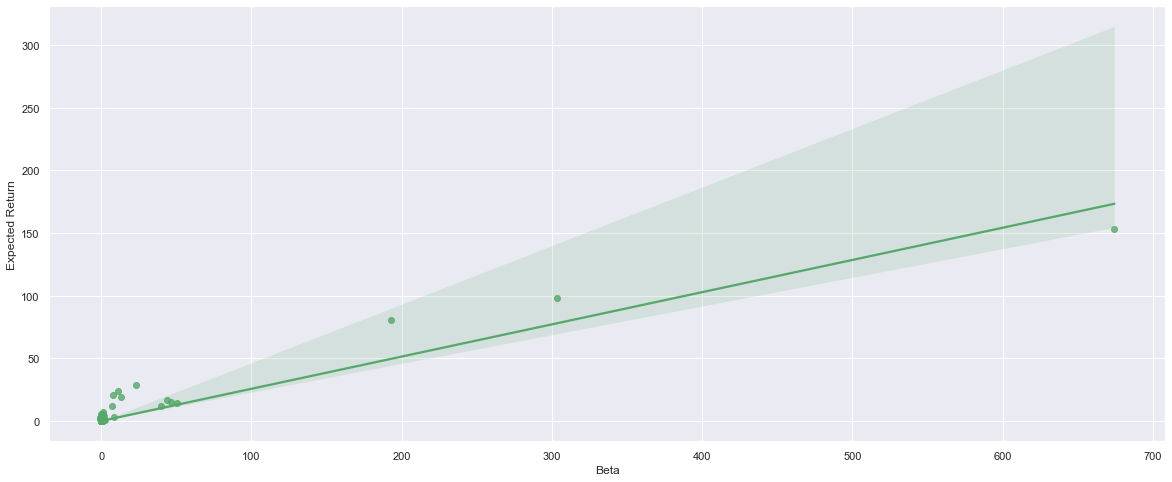

In [82]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "beta", y = "exp_return", data = sml_funds,color="g")
ax.set(xlabel='Beta', ylabel='Expected Return')

print("The Security Market Line can be curated as follows:")
plt.show()

The Expected return of funds vs the alpha against the benchmark fund


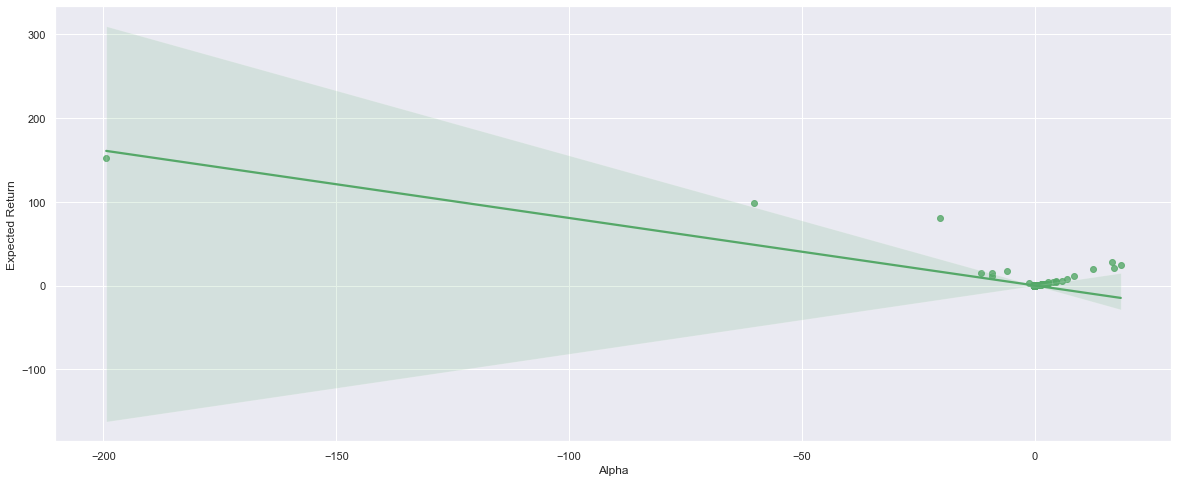

In [83]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "alpha", y = "exp_return", data = sml_funds,color="g")
ax.set(xlabel='Alpha', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("The Expected return of funds vs the alpha against the benchmark fund")
plt.show()

### Inference - Check with Professor Mertens

Most of our funds lie between the Beta of 0 (benchmark) and 50, this shows that most of the funds have not performed extremely well compared to the benchmark

### Use the public (S&P 500) return as a benchmark and compute the SML against that

In [48]:
from yahoofinancials import YahooFinancials

In [49]:
# Timestamp('2000-01-01 00:00:00')
# Timestamp('2021-06-30 00:00:00')

yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2000-01-01', 
                                                  end_date='2021-06-30', 
                                                  time_interval='monthly')
spy_df = pd.DataFrame(data['SPY']['prices'])
spy_df = spy_df.drop('date', axis=1).set_index('formatted_date')
spy_df = spy_df.drop(spy_df.columns[[0, 1, 2, 3, 4]], axis=1) 
spy_df.reset_index(inplace=True)
spy_df.columns = ['transaction_date','sp_500_value']
spy_df.head()

,transaction_date,sp_500_value
0,2000-01-01,92.256
1,2000-02-01,90.852
2,2000-03-01,99.404
3,2000-04-01,96.156
4,2000-05-01,94.645


In [50]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  258 non-null    object 
 1   sp_500_value      258 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [51]:
spy_df['transaction_date'] = pd.to_datetime(spy_df['transaction_date'])

In [52]:
spy_df['transaction_quarter'] = spy_df['transaction_date'].dt.to_period('Q')
spy_df['transaction_year'] = spy_df['transaction_date'].dt.year

In [53]:
spy_df

,transaction_date,sp_500_value,transaction_quarter,transaction_year
0,2000-01-01,92.256,2000Q1,2000
1,2000-02-01,90.852,2000Q1,2000
2,2000-03-01,99.404,2000Q1,2000
3,2000-04-01,96.156,2000Q2,2000
4,2000-05-01,94.645,2000Q2,2000
...,...,...,...,...
253,2021-02-01,372.585,2021Q1,2021
254,2021-03-01,388.228,2021Q1,2021
255,2021-04-01,410.108,2021Q2,2021
256,2021-05-01,412.801,2021Q2,2021


In [54]:
quart_sp500_value = spy_df.groupby(['transaction_quarter']).agg(
    sp500_value=('sp_500_value','mean')
)

quart_sp500_value

# trans_df_series = quart_exp_cf[["fund_name", "transaction_quarter","exp_return"]]
# trans_df_series = trans_df_series.pivot(index='transaction_quarter', columns='fund_name', values='exp_return')

,sp500_value
transaction_quarter,
2000Q1,94.170
2000Q2,95.694
2000Q3,97.199
2000Q4,90.219
2001Q1,84.091
...,...
2020Q2,291.195
2020Q3,327.309
2020Q4,345.448


In [89]:
sp500_returns = (quart_sp500_value/quart_sp500_value.shift(1))-1

sp500_returns = sp500_returns.replace([np.inf, -np.inf], np.nan)
sp500_returns = sp500_returns.fillna(0)

sp500_returns.head(5)

,sp500_value
transaction_quarter,
2000Q1,0.000
2000Q2,0.016
2000Q3,0.016
2000Q4,-0.072
2001Q1,-0.068


In [56]:
beta_sp500 = {}
for col in fund_returns.columns:
    Y = fund_returns[col]
    X = sp500_returns['sp500_value']
    X1 = sm.add_constant(X)
    beta_sp500[col] = sm.OLS(Y, X1).fit().params

In [57]:
beta_spx = pd.DataFrame.from_dict(beta_sp500)
beta_spx=beta_spx.transpose()

In [58]:
beta_spx.reset_index(inplace=True)
beta_spx.columns = ['fund_name','const','beta']
beta_spx.drop(beta_spx.tail(1).index,inplace=True) 
beta_spx.head(5)

,fund_name,const,beta
0,.406 Ventures 2016 Opportunities Fund,0.072,0.532
1,.406 Ventures Fund II,0.040,0.437
2,.406 Ventures Fund III,0.101,-0.522
3,1315 Capital,0.030,0.181
4,1315 Capital II,0.024,0.163


In [59]:
fund_exp_cf=alt_asset_cf.groupby(['fund_name'],as_index=False).agg(
    exp_return=('fund_return','mean'), 
    exp_contr=('cumulative_contribution','mean'),
    exp_distr=('cumulative_distribution','mean')
)

fund_exp_cf.head(5)

,fund_name,exp_return,exp_contr,exp_distr
0,.406 Ventures 2016 Opportunities Fund,-0.877,5158481.542,928527.708
1,.406 Ventures Fund II,-0.798,6535237.933,1997949.000
2,.406 Ventures Fund III,-0.994,3613076.923,45585.385
3,1315 Capital,-0.869,6005128.614,1104492.136
4,1315 Capital II,-1.000,2443070.643,0.000


In [60]:
sml__spx = pd.merge(fund_returns_mean,beta_spx,how = 'inner', on = ['fund_name'])
sml__spx.head(5)

,fund_name,exp_return,const,beta
0,.406 Ventures 2016 Opportunities Fund,0.082,0.072,0.532
1,.406 Ventures Fund II,0.049,0.040,0.437
2,.406 Ventures Fund III,0.091,0.101,-0.522
3,1315 Capital,0.034,0.030,0.181
4,1315 Capital II,0.027,0.024,0.163


In [61]:
sml__spx.describe()

,exp_return,const,beta
count,3835.000,3835.000,3835.000
mean,0.182,0.178,0.232
std,3.345,3.050,21.990
min,-0.078,-0.084,-437.805
25%,0.000,0.000,-0.017
50%,0.022,0.020,0.083
75%,0.045,0.042,0.261
max,152.918,134.706,928.628


The Security Market Line against S&P500 returns can be curated as follows:


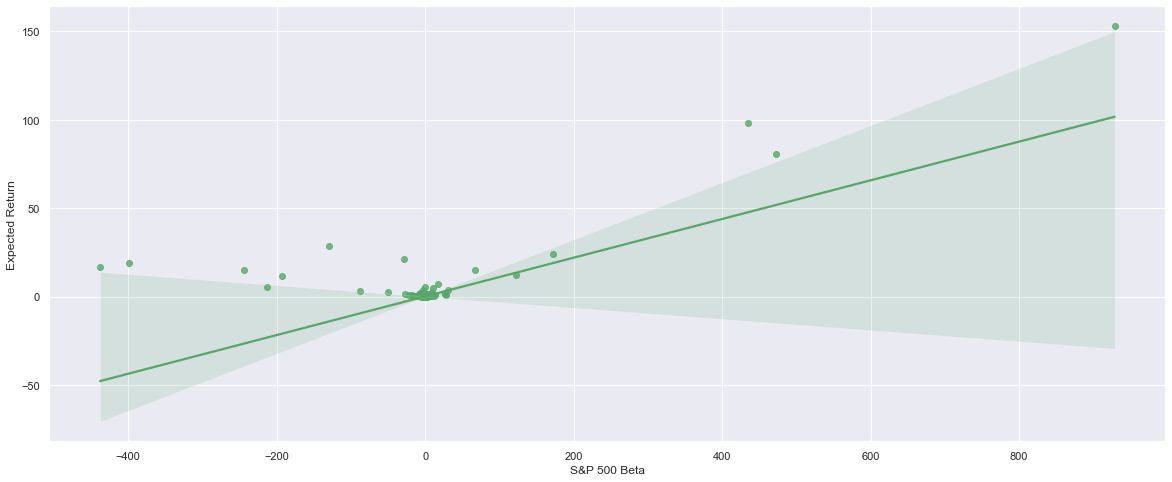

In [62]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "beta", y = "exp_return", data = sml__spx,color="g")
ax.set(xlabel='S&P 500 Beta', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("The Security Market Line against S&P500 returns can be curated as follows:")
plt.show()

Expected returns of the funds against the alpha from S&P500 returns can be curated as follows:


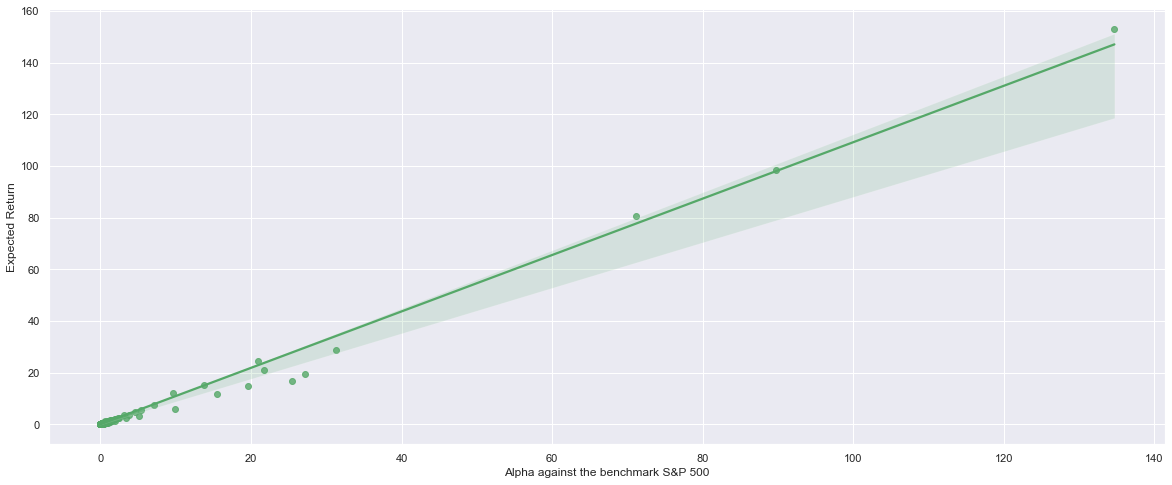

In [63]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "const", y = "exp_return", data = sml__spx,color="g")
ax.set(xlabel='Alpha against the benchmark S&P 500', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("Expected returns of the funds against the alpha from S&P500 returns can be curated as follows:")
plt.show()

### OLS Estimation to check the returns of the PE and VC benchmark against the SP500 

In [64]:
# split dependent and independent variable
y = fund_returns['benchmark_fund']
X = sp500_returns['sp500_value']

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         benchmark_fund   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6604
Date:                Wed, 03 Aug 2022   Prob (F-statistic):              0.419
Time:                        11:40:41   Log-Likelihood:                -136.43
No. Observations:                  86   AIC:                             276.9
Df Residuals:                      84   BIC:                             281.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5539      0.135      4.113      

## A multi-factor model along with SP 500 and macro factors (GDP and CPI) to supplement our analysis

In [65]:
gdp_data = pd.read_csv('gdp_quar.csv')
cpi_data = pd.read_csv('cpi_quar.csv')

In [66]:
gdp_data=gdp_data.rename(columns={'DATE': 'transaction_quarter','GDP':'gdp_value' })
cpi_data=cpi_data.rename(columns={'DATE': 'transaction_quarter','CPIAUCSL':'cpi_value' })

In [67]:
# display(gdp_data.head(5))
# display(cpi_data.head(5))

macro_data = pd.merge(gdp_data,cpi_data,how = 'inner', on = ['transaction_quarter'])
macro_data.head(5)

,transaction_quarter,gdp_value,cpi_value
0,2000-01-01,10002.179,170.100
1,2000-04-01,10247.720,171.433
2,2000-07-01,10318.165,173.000
3,2000-10-01,10435.744,174.233
4,2001-01-01,10470.231,175.900


In [68]:
macro_data['transaction_quarter'] = pd.to_datetime(macro_data['transaction_quarter'])

In [69]:
macro_data['transaction_quarter'] = macro_data['transaction_quarter'].dt.to_period('Q')

In [70]:
macro_data.head(5)

,transaction_quarter,gdp_value,cpi_value
0,2000Q1,10002.179,170.100
1,2000Q2,10247.720,171.433
2,2000Q3,10318.165,173.000
3,2000Q4,10435.744,174.233
4,2001Q1,10470.231,175.900


In [71]:
macro_data = macro_data.groupby(['transaction_quarter']).agg(
    gdp_value=('gdp_value','mean'),
    cpi_value=('cpi_value','mean')
)

macro_data

,gdp_value,cpi_value
transaction_quarter,,
2000Q1,10002.179,170.100
2000Q2,10247.720,171.433
2000Q3,10318.165,173.000
2000Q4,10435.744,174.233
2001Q1,10470.231,175.900
...,...,...
2020Q2,19477.444,256.418
2020Q3,21138.574,259.438
2020Q4,21477.597,260.879


In [72]:
macro_change = (macro_data/macro_data.shift(1))-1

macro_change = macro_change.replace([np.inf, -np.inf], np.nan)
macro_change = macro_change.fillna(0)

macro_change.head(10)

,gdp_value,cpi_value
transaction_quarter,,
2000Q1,0.000,0.000
2000Q2,0.025,0.008
2000Q3,0.007,0.009
2000Q4,0.011,0.007
2001Q1,0.003,0.010
2001Q2,0.012,0.007
2001Q3,-0.000,0.003
2001Q4,0.006,-0.001
2002Q1,0.012,0.003


In [73]:
mutli_factor_change = pd.merge(macro_change,sp500_returns,how = 'inner', on = ['transaction_quarter'])

In [74]:
mutli_factor_change

,gdp_value,cpi_value,sp500_value
transaction_quarter,,,
2000Q1,0.000,0.000,0.000
2000Q2,0.025,0.008,0.016
2000Q3,0.007,0.009,0.016
2000Q4,0.011,0.007,-0.072
2001Q1,0.003,0.010,-0.068
...,...,...,...
2020Q2,-0.093,-0.009,0.037
2020Q3,0.085,0.012,0.124
2020Q4,0.016,0.006,0.055


In [75]:
beta_mutli = {}
for col in fund_returns.columns:
    Y = fund_returns[col]
    X = mutli_factor_change[['gdp_value','cpi_value','sp500_value']]
    X1 = sm.add_constant(X)
    beta_mutli[col] = sm.OLS(Y, X1).fit().params

In [76]:
beta_mf = pd.DataFrame.from_dict(beta_mutli)
beta_mf=beta_mf.transpose()

beta_mf.reset_index(inplace=True)
beta_mf.columns = ['fund_name','alpha','beta_gdp','beta_cpi','beta_sp500']
beta_mf.drop(beta_mf.tail(1).index,inplace=True) 
beta_mf.head(5)

,fund_name,alpha,beta_gdp,beta_cpi,beta_sp500
0,.406 Ventures 2016 Opportunities Fund,0.099,0.156,-5.870,0.680
1,.406 Ventures Fund II,0.055,2.154,-6.815,0.464
2,.406 Ventures Fund III,0.131,1.809,-9.388,-0.399
3,1315 Capital,0.044,-0.418,-2.109,0.269
4,1315 Capital II,0.023,-0.229,0.631,0.163


In [77]:
sml_multi = pd.merge(fund_returns_mean,beta_mf,how = 'inner', on = ['fund_name'])
sml_multi.head(5)

,fund_name,exp_return,alpha,beta_gdp,beta_cpi,beta_sp500
0,.406 Ventures 2016 Opportunities Fund,0.082,0.099,0.156,-5.870,0.680
1,.406 Ventures Fund II,0.049,0.055,2.154,-6.815,0.464
2,.406 Ventures Fund III,0.091,0.131,1.809,-9.388,-0.399
3,1315 Capital,0.034,0.044,-0.418,-2.109,0.269
4,1315 Capital II,0.027,0.023,-0.229,0.631,0.163


In [78]:
sml_multi.describe()

,exp_return,alpha,beta_gdp,beta_cpi,beta_sp500
count,3835.000,3835.000,3835.000,3835.000,3835.000
mean,0.182,0.211,0.315,-7.426,0.412
std,3.345,4.613,52.398,503.460,30.598
min,-0.078,-7.304,-1531.552,-26494.304,-552.858
25%,0.000,-0.002,-0.547,-2.361,-0.032
50%,0.022,0.018,0.000,-0.088,0.089
75%,0.045,0.047,0.604,1.938,0.288
max,152.918,182.428,2199.509,9783.052,1213.969


Expected returns of the funds against the alpha from multi-factor model can be curated as follows:


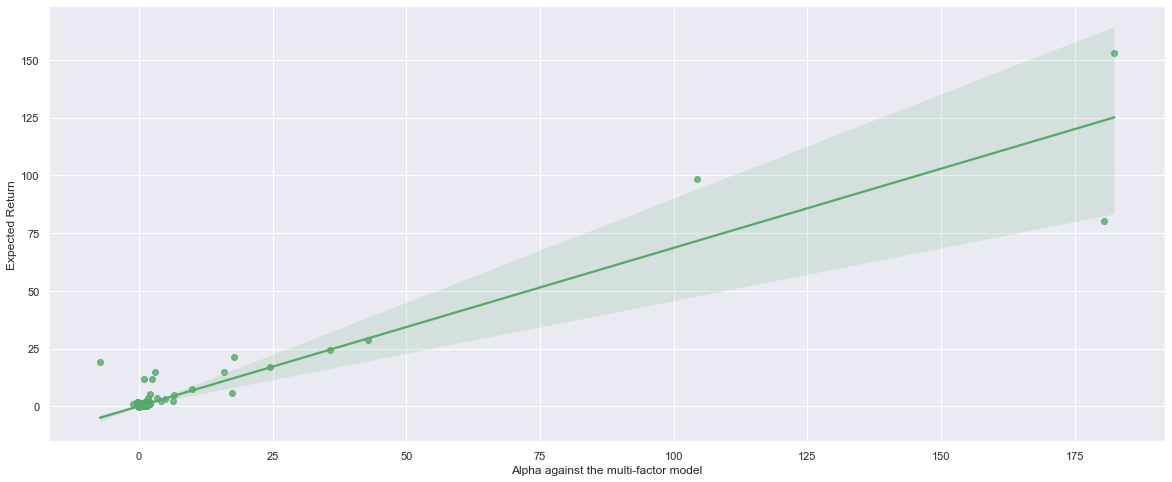

In [79]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "alpha", y = "exp_return", data = sml_multi,color="g")
ax.set(xlabel='Alpha against the multi-factor model', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("Expected returns of the funds against the alpha from multi-factor model can be curated as follows:")
plt.show()

The Security Market Line against GDP change from a multi factor model can be curated as follows:


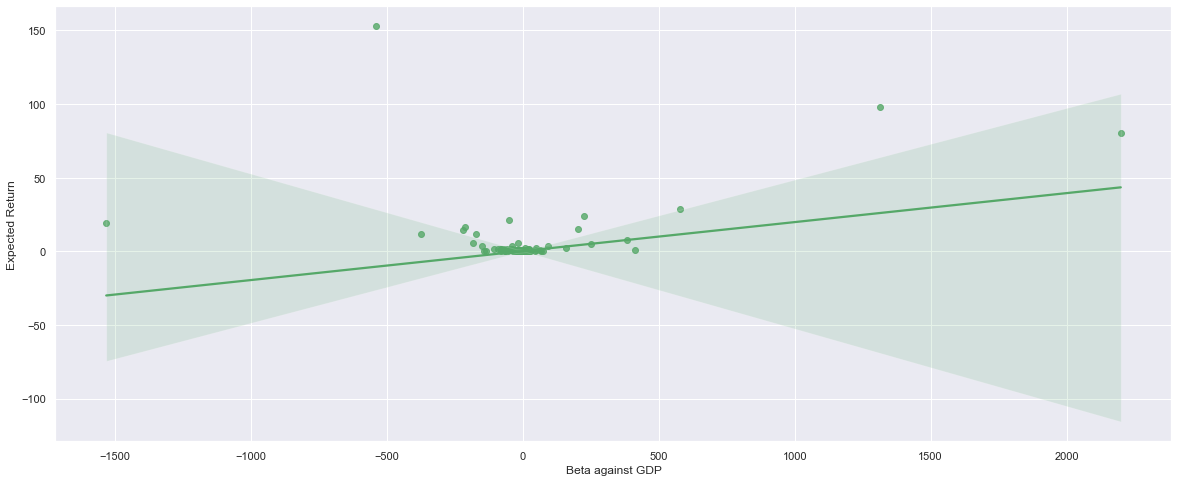

The Security Market Line against CPI change from a multi factor model can be curated as follows:


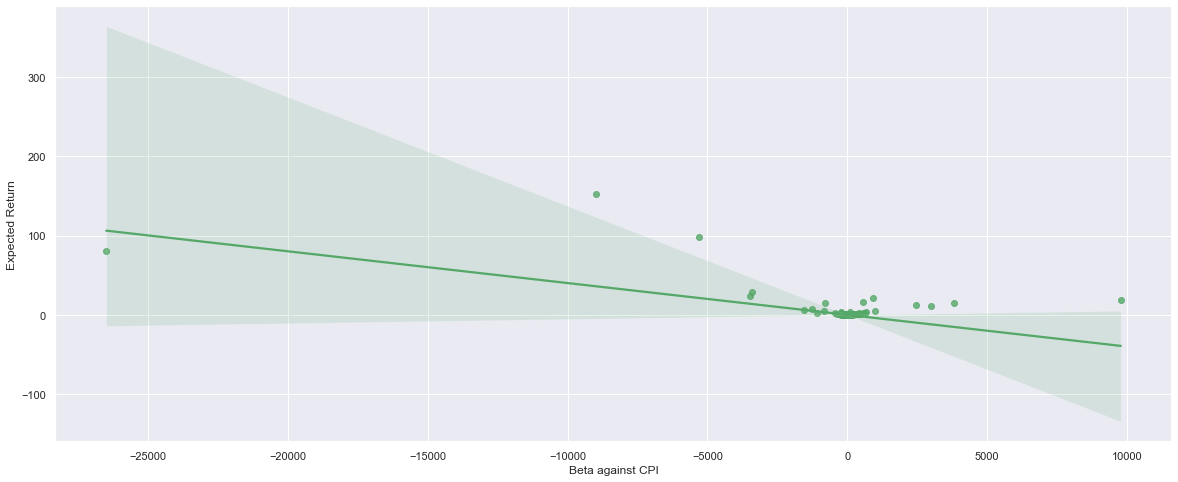

The Security Market Line against SP500 change from a multi factor model can be curated as follows:


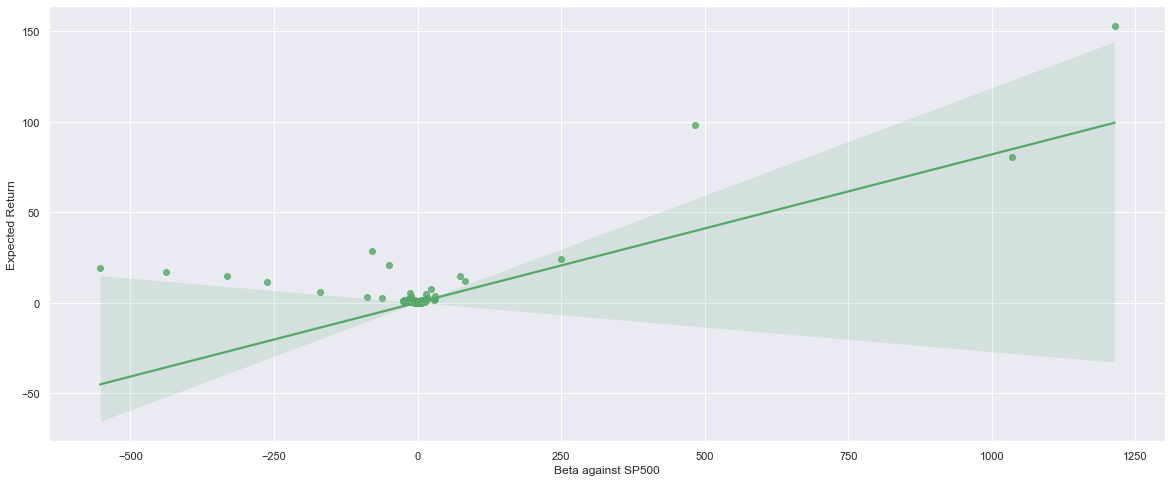

In [80]:
sns.set_theme(style="darkgrid")

ax=sns.regplot(x = "beta_gdp", y = "exp_return", data = sml_multi,color="g")
ax.set(xlabel='Beta against GDP', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("The Security Market Line against GDP change from a multi factor model can be curated as follows:")
plt.show()

ax=sns.regplot(x = "beta_cpi", y = "exp_return", data = sml_multi,color="g")
ax.set(xlabel='Beta against CPI', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("The Security Market Line against CPI change from a multi factor model can be curated as follows:")
plt.show()

ax=sns.regplot(x = "beta_sp500", y = "exp_return", data = sml_multi,color="g")
ax.set(xlabel='Beta against SP500', ylabel='Expected Return')

sns.set(rc = {'figure.figsize':(20,8)})

print("The Security Market Line against SP500 change from a multi factor model can be curated as follows:")
plt.show()

### OLS Estimation to check the returns of the PE and VC benchmark against the multi-factor changes

In [81]:
# split dependent and independent variable
y = fund_returns['benchmark_fund']
X = mutli_factor_change[['gdp_value','cpi_value','sp500_value']]

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         benchmark_fund   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.2482
Date:                Wed, 03 Aug 2022   Prob (F-statistic):              0.862
Time:                        11:40:58   Log-Likelihood:                -136.38
No. Observations:                  86   AIC:                             280.8
Df Residuals:                      82   BIC:                             290.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5291      0.181      2.920      

---